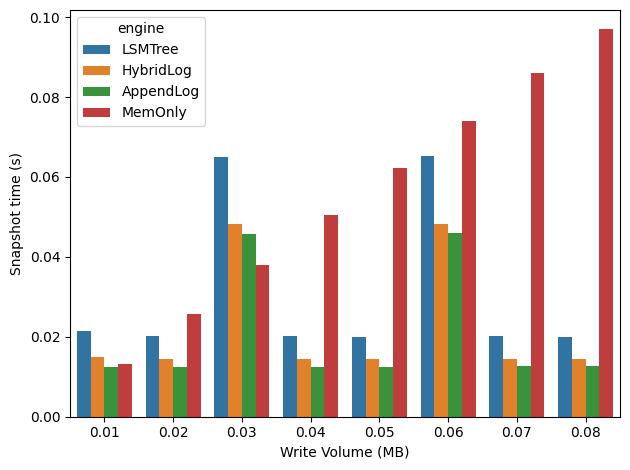

In [7]:
# when state is the zero and we only do updates

import sys
from random import Random
import pandas as pd
import seaborn as sns
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_snapshot_time(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    rng = Random(1)
    klen = 2
    vlen = 8
    start = 1_000
    incr = 1_000
    n = 7

    size_so_far = 0
    aggr_time = 0

    for _ in range(start):
        db[rng.randbytes(klen)] = rng.randbytes(vlen)
    with Timer() as t:
        db.snapshot(0)
    size_so_far += start * (klen + vlen)
    aggr_time += float(t)
    row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1_000_000}
    res.append(row)
    row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1_000_000}
    res.append(row)

    for i in range(1, n + 1):
        for _ in range(incr):
            db[rng.randbytes(klen)] = rng.randbytes(vlen)
        with Timer() as t:
            db.snapshot(i)
        size_so_far += incr * (klen + vlen)
        aggr_time += float(t)
        row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1_000_000}
        res.append(row)
        row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1_000_000}
        res.append(row)

    return res

latency = 10**(-6)
df = run(
    [2], [8], [1], [1],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog, MemOnly], [{
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [1_000_000],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    },
    {
        'max_runs_per_level': [3],
        'ro_lag_interval': [100_000],
        'flush_interval': [100_000],
        'hash_index': ['dict'],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    },
    {
        'max_runs_per_level': [3],
        'threshold': [1_000_000],
        'compaction': [False],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)],
    },
    {
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    }],
    [measure_snapshot_time], {}
)


data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]


barplot(data=data, x='write_volume', y='value', hue='engine',
         filename='snapshot.pdf', xlabel='Write Volume (MB)',
         ylabel='Snapshot time (s)')


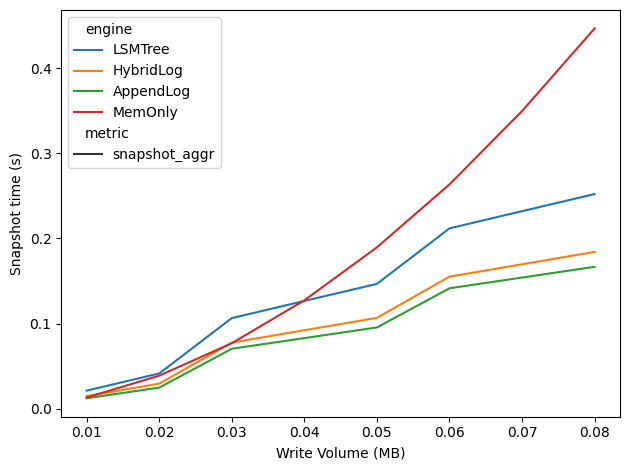

In [8]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot_aggr'])]


lineplot(data=data, x='write_volume', y='value', hue='engine', style='metric',
         filename='snapshot-aggr.pdf', xlabel='Write Volume (MB)',
         ylabel='Snapshot time (s)')

In [10]:
# when state is the same and we only do updates

import sys
from random import Random
import pandas as pd
import seaborn as sns
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_snapshot_time(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    rng = Random(1)
    klen = 2
    vlen = 8
    start = 100_000_000
    incr = 1_000
    n = 20

    size_so_far = 0
    aggr_time = 0

    for _ in range(start):
        db[rng.randbytes(klen)] = rng.randbytes(vlen)
    with Timer() as t:
        db.snapshot(0)
    size_so_far += start * (klen + vlen)
    aggr_time += float(t)
    print(size_so_far)
    row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far}
    res.append(row)
    row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far}
    print(db.name, row)
    res.append(row)

    for i in range(1, n + 1):
        for _ in range(incr):
            db[rng.randbytes(klen)] = rng.randbytes(vlen)
        with Timer() as t:
            db.snapshot(i)
        size_so_far += incr * (klen + vlen)
        aggr_time += float(t)
        row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far}
        res.append(row)
        row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far}
        # print(db.name, row)
        res.append(row)

    return res

latency = 10**(-6)
df = run(
    [2], [8], [1], [1],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog, MemOnly], [{
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [1_000_000],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    },
    {
        'max_runs_per_level': [3],
        'ro_lag_interval': [100_000],
        'flush_interval': [100_000],
        'hash_index': ['dict'],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    },
    {
        'max_runs_per_level': [3],
        'threshold': [1_000_000],
        'compaction': [False],
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)],
    },
    {
        'remote': [PathRemote('/tmp/remote', latency_per_byte=latency)]
    }],
    [measure_snapshot_time], {}
)


data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]
data['write_volume'] = data['write_volume'] / 1000000000

# p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
# p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
# p.set_xlabel('Write Volume (GB)')
# p.set_ylabel('Snapshot time (s)')
# p.figure.savefig("snapshot-static-state.png", bbox_inches='tight')

1000000000
LSMTree {'metric': 'snapshot_aggr', 'value': 1.3811969757080078, 'write_volume': 1000000000}
1000000000
HybridLog {'metric': 'snapshot_aggr', 'value': 1.0212643146514893, 'write_volume': 1000000000}
1000000000
AppendLog {'metric': 'snapshot_aggr', 'value': 3.5638532638549805, 'write_volume': 1000000000}
1000000000
MemOnly {'metric': 'snapshot_aggr', 'value': 0.8423130512237549, 'write_volume': 1000000000}


/tmp/ipykernel_400/3826648796.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)


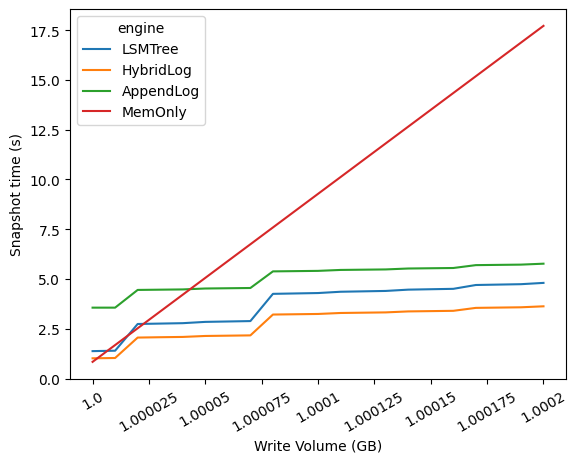

In [13]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot_aggr'])]
data['write_volume'] = data['write_volume'] / 1000000000

p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
p.set_xlabel('Write Volume (GB)')
p.set_ylabel('Snapshot time (s)')
p.figure.savefig("snapshot-static-state-aggr.pdf", bbox_inches='tight')

/tmp/ipykernel_400/1658599520.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)


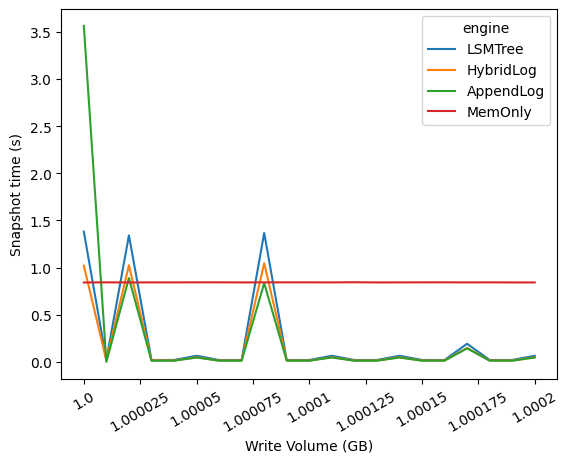

In [14]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]
data['write_volume'] = data['write_volume'] / 1000000000

p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
p.set_xlabel('Write Volume (GB)')
p.set_ylabel('Snapshot time (s)')
p.figure.savefig("snapshot-static-state.pdf", bbox_inches='tight')